In [1]:
import pandas as pd 
import numpy as np
import os
from joblib import dump
import pickle as pkl
import pickle
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


from sklearn.metrics import make_scorer, fbeta_score,  mean_squared_error, r2_score, f1_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [96]:
train_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/train_df.csv')
eval_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/eval_df.csv')
test_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/test_df.csv')

"""
selected_features = ['Fwd IAT Total', 'Fwd Packet Length Max',
        'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Bwd Packets Length Total', 'Bwd Packet Length Max',
        'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
        'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size']
"""

#X_train = train_df[selected_features]  # Features from the training data
X_train = train_df.drop(['Label', 'Attack'], axis=1)
y_train = train_df['Attack'] 

#X_eval = eval_df[selected_features]  # Features from the evaluation data
X_eval = eval_df.drop(['Label', 'Attack'], axis=1)
y_eval = eval_df['Attack']

#X_test = test_df[selected_features]
X_test = test_df.drop(['Label', 'Attack'], axis=1)
y_test = test_df['Attack']

In [97]:
# Initialize scaler
scaler = StandardScaler()

# Scale the features
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Applying the 'trained' scaler on eval and test
X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# baseline models

In [4]:
def run_on_splits(func):
    def _run_loop(model, model_name):
        for X, y, nsplit in zip([X_train, X_eval], 
                                [y_train, y_eval],  
                                ['train', 'val']):
            func(model, X=X, y=y, nsplit=nsplit, model_name=model_name, beta=2)  # F2 score optimization
    return _run_loop

In [5]:
@run_on_splits 
def evaluate_splits(model, X, y, nsplit, model_name, beta=2):
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)

    # Calculating F scores for the given beta
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    best_idx = np.nanargmax(f_scores)  # Using nanargmax to ignore NaNs in the calculation
    best_threshold = thresholds[best_idx]

    predictions = (probabilities >= best_threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, zero_division=0)  # Handle zero division case
    rec = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions)
    f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec) + rec)
    roc_auc = roc_auc_score(y, probabilities) 

    # Store performances
    performances.append({
        'model': model_name,
        'split': nsplit,
        'threshold': best_threshold,
        'accuracy': acc,'precision': prec,'recall': rec,'f1': f1,
        'f2': f2,'roc_auc': roc_auc,'beta': beta})

    if nsplit == 'val':
        report = classification_report(y, predictions)
        cm = confusion_matrix(y, predictions)

        # Save the classification report as TXT
        report_path = f'../output/first_evaluation/{model_name}_classification_report.txt'
        with open(report_path, 'w') as f:
            f.write(report)

        # Generate and save onfusion matrix as JPEG
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])
        plt.tight_layout()
        
        matrix_path = f'../output/first_evaluation/{model_name}_confusion_matrix.jpeg'
        plt.savefig(matrix_path)
        plt.close(fig)
        print(f"Saved confusion matrix for {model_name} at {matrix_path}")
    return

"""
def load_and_evaluate(model_filename, model_name):
model = load(model_filename)
evaluate(model, model_name=model_name)
"""

'\ndef load_and_evaluate(model_filename, model_name):\nmodel = load(model_filename)\nevaluate(model, model_name=model_name)\n'

In [6]:
def train_and_save(model, X_train, y_train, filename):
    """Train a model and save it."""
    model.fit(X_train, y_train)
    dump(model, filename)
    return model

In [7]:
# specify baseline models, with tuning from gridsearch
models = {
    'Dummy_Classifier': DummyClassifier(strategy='most_frequent', random_state=42),
    'Baseline_log_reg': LogisticRegression(max_iter=1000, random_state=42),
    'Baseline_SVM': svm.SVC(kernel='linear', probability=True, random_state=42),
    'Baseline_KNN': KNeighborsClassifier(n_neighbors=10),
    'Baseline_RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'Tuned_RF': RandomForestClassifier(n_estimators=110, max_depth=40, min_samples_leaf=1, min_samples_split=10, random_state=42),
    'Baseline_XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
    'Tuned_XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False, colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=10, n_estimators=350, subsample=0.5, eval_metric='logloss')
}

trained_models = {}  # Dictionary to store trained model references

for name, model in models.items():
    trained_model = train_and_save(model, X_train, y_train, f'../models/first_models/{name}.joblib')
    trained_models[name] = trained_model  # Store the trained model for later use


In [8]:
performances = []  # To store performance results

for name, model in trained_models.items():
    evaluate_splits(model, model_name=name)

/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Saved confusion matrix for Dummy_Classifier at ../output/first_evaluation/Dummy_Classifier_confusion_matrix.jpeg
Saved confusion matrix for Baseline_log_reg at ../output/first_evaluation/Baseline_log_reg_confusion_matrix.jpeg
Saved confusion matrix for Baseline_SVM at ../output/first_evaluation/Baseline_SVM_confusion_matrix.jpeg
Saved confusion matrix for Baseline_KNN at ../output/first_evaluation/Baseline_KNN_confusion_matrix.jpeg
Saved confusion matrix for Baseline_RF at ../output/first_evaluation/Baseline_RF_confusion_matrix.jpeg
Saved confusion matrix for Tuned_RF at ../output/first_evaluation/Tuned_RF_confusion_matrix.jpeg
Saved confusion matrix for Baseline_XGB at ../output/first_evaluation/Baseline_XGB_confusion_matrix.jpeg
Saved confusion matrix for Tuned_XGB at ../output/first_evaluation/Tuned_XGB_confusion_matrix.jpeg


In [86]:
perf_df = pd.DataFrame(performances)
perf_df

,model,features,threshold,accuracy,precision,recall,f1,f2,roc_auc
0,Baseline_RF_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.780000,0.992433,0.967478,0.983363,0.975356,0.980144,0.997887
1,Tuned_RF_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.629748,0.991567,0.960709,0.984895,0.972652,0.979961,0.999043
2,Tuned_RF_Permutation_Features,"[Fwd IAT Total, Bwd Packet Length Std, Bwd Pac...",0.610204,0.991567,0.961497,0.984019,0.972628,0.979431,0.999134
3,Baseline_XGB_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.877578,0.994633,0.988473,0.976138,0.982267,0.978581,0.999419
4,Tuned_XGB_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.783102,0.992367,0.968878,0.981392,0.975095,0.978864,0.999329
5,Tuned_XGB_Permutation_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.828708,0.993300,0.978104,0.977890,0.977997,0.977932,0.999270
6,Tuned_XGB_RFECV_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.783102,0.992367,0.968878,0.981392,0.975095,0.978864,0.999329


verify results:

In [15]:
# plotting
# if df path exists, use, otherwise create from performances

def plot_model_splits(performances, metric='f2'):
    # Create DataFrame from performances and filter val set
    perf_df = pd.DataFrame(performances)
    val_perf = perf_df[perf_df['split'] == 'val'].sort_values(by=metric, ascending=False)

    # sort the full DataFrame based on the order of the val set performance
    perf_df['model'] = pd.Categorical(perf_df['model'], categories=val_perf['model'], ordered=True)
    perf_df = perf_df.sort_values('model')

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                   y='model', 
                                   x=metric, 
                                   hue='split',
                                   style='split', 
                                   markers={       # Define markers for each split
                                       'train': 'o',
                                       'val': '^',
                                   },
                                   palette=['grey', 'darkorange'],
                                   alpha=0.8)  # Adjust alpha transparency for all markers

    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    # Specify the plot path and save
    plt.tight_layout() 
    plot_path = f'../output/plots/{metric}_performance_splits.jpeg'
    plt.savefig(plot_path)

    plt.show()
    return

def plot_model_metric(performances, metric='f2'):
    perf_df = pd.DataFrame(performances)
    
    # sort the full DataFrame based on the order of performance
    perf_df = perf_df.sort_values(by=metric, ascending=False)

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                    x=metric, 
                                    y='model',
                                    alpha=0.7)
    
    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    # Specify the plot path and save
    plt.tight_layout() 
    plot_path = f'../output/plots/{metric}_performance_fm.jpeg'
    plt.savefig(plot_path)
    plt.show()
    return

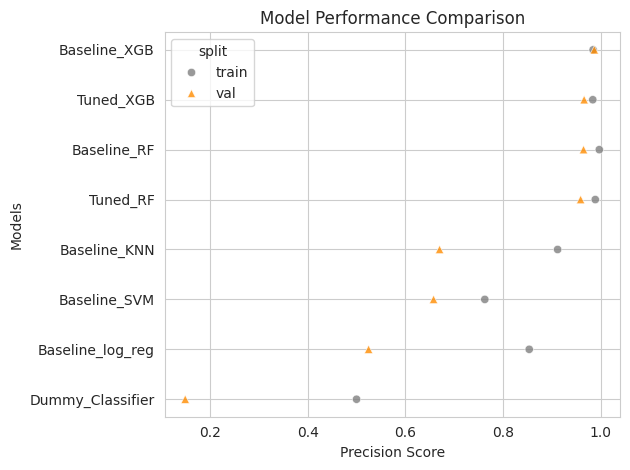

In [46]:
plot_model_splits(performances, metric='precision')
# update save in function

identify best models from baseline:

In [16]:
# Create DataFrame from performances
perf_df = pd.DataFrame(performances)

# Filter for test split and sort by F2 score
top_models = perf_df[perf_df['split'] == 'val'].sort_values(by='f2', ascending=False).head(4)
top_models

,model,split,threshold,accuracy,precision,recall,f1,f2,roc_auc,beta
11,Tuned_RF,val,0.629748,0.992200,0.958549,0.990629,0.974325,0.984043,0.998995,2
15,Tuned_XGB,val,0.783102,0.993067,0.965780,0.988621,0.977067,0.983967,0.999330,2
13,Baseline_XGB,val,0.877578,0.995467,0.986565,0.983043,0.984801,0.983746,0.999425,2
9,Baseline_RF,val,0.780000,0.992833,0.964511,0.988398,0.976309,0.983526,0.997880,2


Results for Tuned_RF:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     25518
           1       0.96      0.99      0.97      4482

    accuracy                           0.99     30000
   macro avg       0.98      0.99      0.98     30000
weighted avg       0.99      0.99      0.99     30000



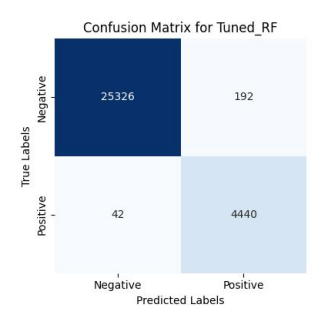

Results for Tuned_XGB:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     25518
           1       0.97      0.99      0.98      4482

    accuracy                           0.99     30000
   macro avg       0.98      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



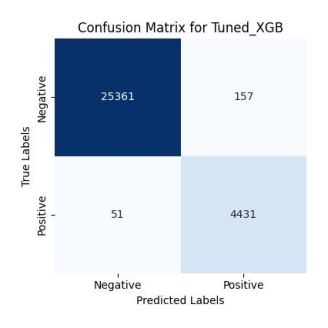

Results for Baseline_XGB:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25518
           1       0.99      0.98      0.98      4482

    accuracy                           1.00     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       1.00      1.00      1.00     30000



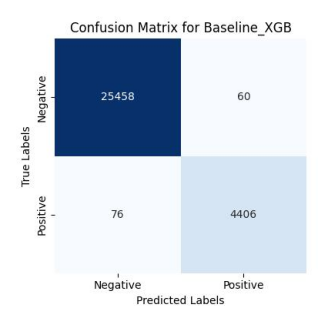

Results for Baseline_RF:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     25518
           1       0.96      0.99      0.98      4482

    accuracy                           0.99     30000
   macro avg       0.98      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



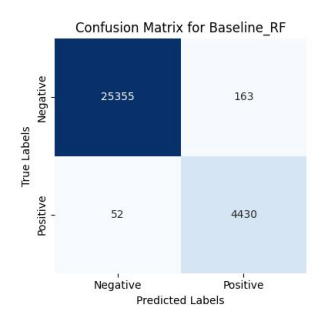

In [56]:
# loop over 'top_models' DataFrame and print cr and cm created above
for _, row in top_models.iterrows():
    model_name = row['model']
    # Construct paths based on how files were saved
    report_path = f'../output/first_evaluation/{model_name}_classification_report.txt'
    matrix_path = f'../output/first_evaluation/{model_name}_confusion_matrix.jpeg'

    # Load and print the classification report
    with open(report_path, 'r') as file:
        report = file.read()
    print(f"Results for {model_name}:\n{report}")

    # Display the confusion matrix image
    img = mpimg.imread(matrix_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# best models

In [85]:
def train_and_save(model, X_train, y_train, filename):
    """Train a model and save it to a specified filename."""
    model.fit(X_train, y_train)
    dump(model, filename)
    return model

def optimize_threshold(model, X, y, beta=2):
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    best_idx = np.nanargmax(f_scores)
    best_threshold = thresholds[best_idx]
    return best_threshold

def evaluate_and_save(model, y, predictions, probabilities, best_threshold, model_name, feature_subset):
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, zero_division=0)
    rec = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions, zero_division=0)
    f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec + rec))
    roc_auc = roc_auc_score(y, probabilities)

    # appending results
    performances.append({
        'model': model_name,
        'features': feature_subset,
        'threshold': best_threshold, 'accuracy': acc,'precision': prec,'recall': rec,
        'f1': f1,'f2': f2,'roc_auc': roc_auc})
    
    report = classification_report(y, predictions)
    cm = confusion_matrix(y, predictions)

    # Save the classification report as TXT
    report_path = f'../output/final_models/{model_name}_classification_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)

    # Generate and save onfusion matrix as JPEG
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])
    plt.tight_layout()
    
    matrix_path = f'../output/final_models/{model_name}_confusion_matrix.jpeg'
    plt.savefig(matrix_path)
    plt.close(fig)
    print(f"Saved results for {model_name} at {matrix_path}")
    return

def process_model(model, feature_subset, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    # Subset the features for the different datasets
    X_train_subset = X_train[feature_subset]
    X_val_subset = X_val[feature_subset]
    X_test_subset = X_test[feature_subset]

    # Train the model
    filename = f"../models/final_models/{model_name}_model.joblib"
    trained_model = train_and_save(model, X_train_subset, y_train, filename)

    # Optimize threshold on validation set
    best_threshold = optimize_threshold(trained_model, X_val_subset, y_val)

    # Apply model to the test set using the optimized threshold
    probabilities = trained_model.predict_proba(X_test_subset)[:, 1]
    predictions = (probabilities >= best_threshold).astype(int)

    # create predictions and save results
    evaluate_and_save(trained_model, y_test, predictions, probabilities, best_threshold, model_name, feature_subset)
    return predictions


 running Baseline_RF_Absolute_Features with ['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'C

Saved results for Baseline_RF_Absolute_Features at ../output/final_models/Baseline_RF_Absolute_Features_confusion_matrix.jpeg

 running Baseline_RF_All_Features with ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size'] and base model Baseline_RF
Saved results for Baseline_RF_All_Features at ../output/final_models/Baseline_RF_All_Features_confusion_matrix.jpeg

 running Tuned_RF_All_Features with ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size'] and 

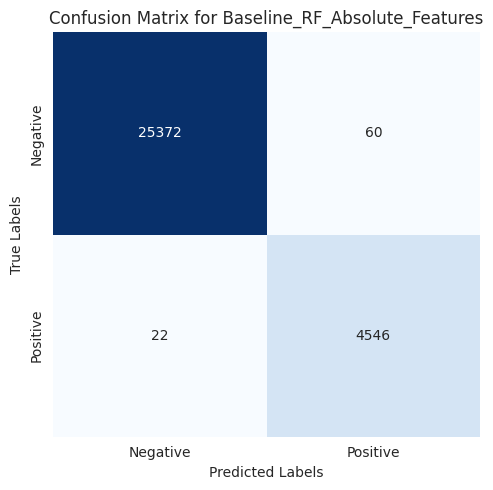

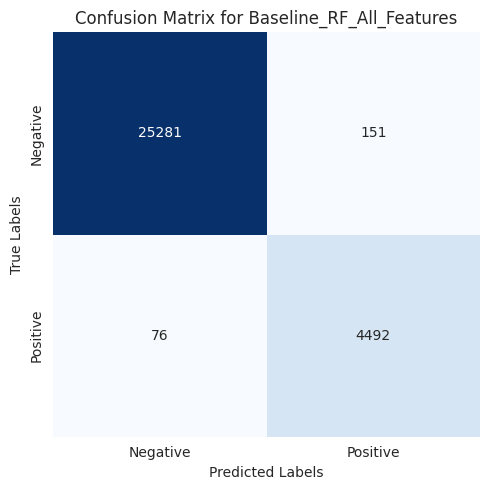

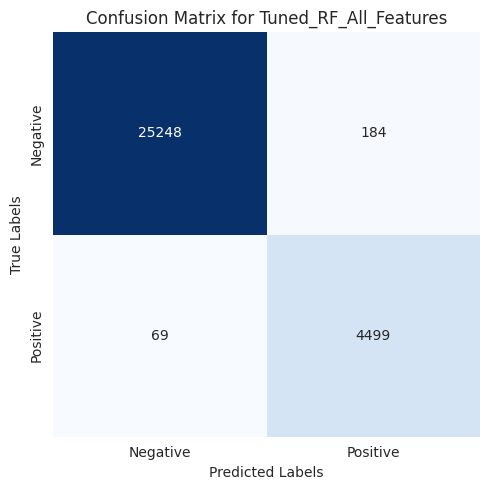

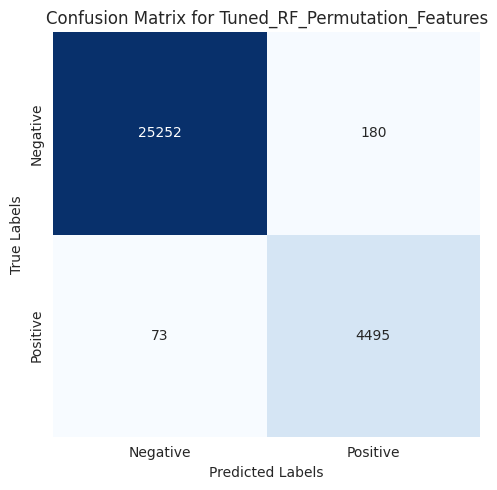

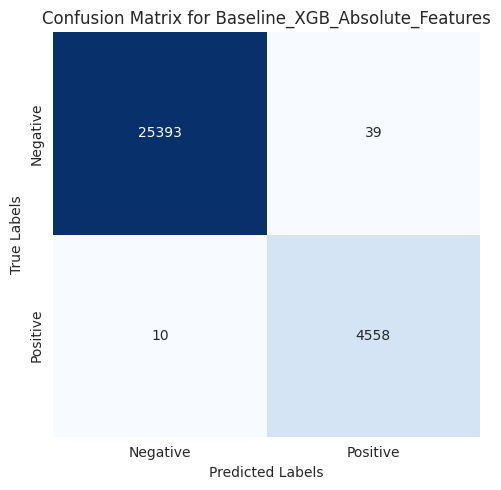

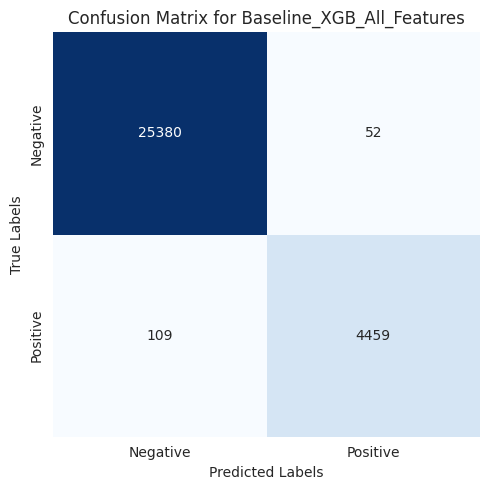

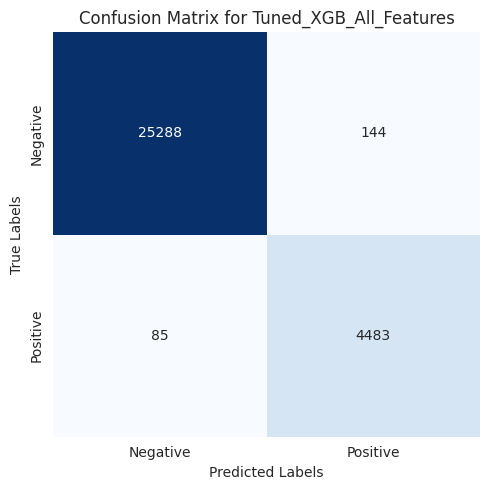

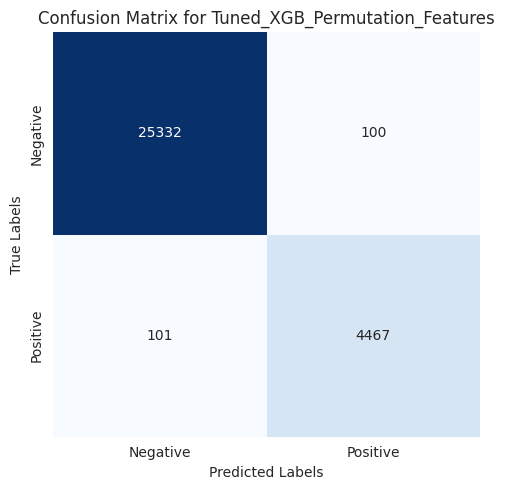

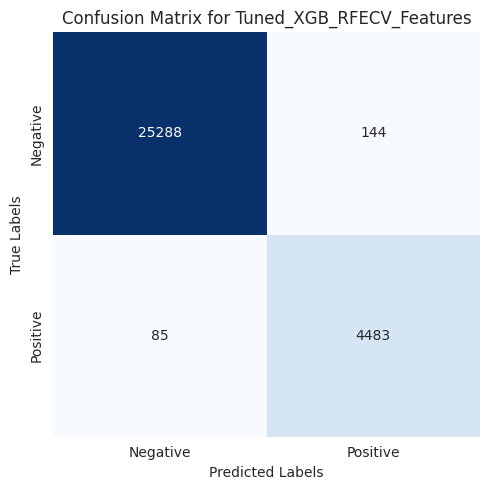

In [98]:
models = {
    'Baseline_RF': RandomForestClassifier(n_estimators=100, random_state=42),

    'Tuned_RF': RandomForestClassifier(n_estimators=110, max_depth = 40, min_samples_leaf=1,
                                        min_samples_split = 10, random_state=42),

    'Baseline_XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False),

    'Tuned_XGB': XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                                colsample_bytree=1.0, gamma=0.5,learning_rate=0.3, max_depth=10,
                                n_estimators=350, subsample=0.5, eval_metric='logloss') 
}

all_features = ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                              'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean',
                              'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
                              'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

absolute_features = [col for col in X_train.columns]

models_config = {
    'Baseline_RF_Absolute_Features': absolute_features,
    'Baseline_RF_All_Features': all_features,
    'Tuned_RF_All_Features': all_features,
    'Tuned_RF_Permutation_Features': ['Fwd IAT Total', 'Bwd Packet Length Std', 'Bwd Packets Length Total',
                                   'Packet Length Mean', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size',
                                   'Avg Bwd Segment Size'],
    'Baseline_XGB_Absolute_Features': absolute_features,                               
    'Baseline_XGB_All_Features': all_features,
    'Tuned_XGB_All_Features': all_features,
    'Tuned_XGB_Permutation_Features': ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                                       'Packet Length Std', 'Avg Packet Size', 'Fwd Header Length'],
    'Tuned_XGB_RFECV_Features': ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                                 'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean',
                                 'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size']
}

all_predictions = test_df
performances = []

# Iterating over configurations
for model_name, features in models_config.items():
    # Extract the base model name (before the underscore)
    base_model_name = '_'.join(model_name.split('_')[:2])
    print(f'\n running {model_name} with {features} and base model {base_model_name}')                  # back to test
    predictions = process_model(models[base_model_name], features, X_train, y_train, X_eval, y_eval, X_test, y_test, model_name)
    # Add predictions to the DataFrame
    all_predictions[f'{model_name}_Predictions'] = predictions

In [87]:
val_results_df = pd.DataFrame(performances)
val_results_df['split'] = 'Val'
val_results_df                             

,model,features,threshold,accuracy,precision,recall,f1,f2,roc_auc,split
0,Baseline_RF_Absolute_Features,"[Protocol, Flow Duration, Total Fwd Packets, T...",0.540000,0.997067,0.985203,0.995315,0.990233,0.993276,0.999842,Val
1,Baseline_RF_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.780000,0.992833,0.964511,0.988398,0.976309,0.983526,0.997880,Val
2,Tuned_RF_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.629748,0.992200,0.958549,0.990629,0.974325,0.984043,0.998995,Val
3,Tuned_RF_Permutation_Features,"[Fwd IAT Total, Bwd Packet Length Std, Bwd Pac...",0.610204,0.992033,0.957713,0.990406,0.973785,0.983690,0.998933,Val
4,Baseline_XGB_Absolute_Features,"[Protocol, Flow Duration, Total Fwd Packets, T...",0.538581,0.997933,0.988722,0.997546,0.993114,0.995768,0.999938,Val
5,Baseline_XGB_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.877578,0.995467,0.986565,0.983043,0.984801,0.983746,0.999425,Val
6,Tuned_XGB_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.783102,0.993067,0.965780,0.988621,0.977067,0.983967,0.999330,Val
7,Tuned_XGB_Permutation_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.828708,0.993967,0.973992,0.985944,0.979931,0.983530,0.999311,Val
8,Tuned_XGB_RFECV_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.783102,0.993067,0.965780,0.988621,0.977067,0.983967,0.999330,Val


In [91]:
full_results = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/val_test_performances.csv')
full_results

,model,features,threshold,accuracy,precision,recall,f1,f2,roc_auc,split
0,Baseline_RF_Absolute_Features,"['Protocol', 'Flow Duration', 'Total Fwd Packe...",0.540000,0.997267,0.986974,0.995184,0.991062,0.993531,0.999855,Test
1,Baseline_RF_All_Features,"['Fwd IAT Total', 'Fwd Packet Length Max', 'Bw...",0.780000,0.992433,0.967478,0.983363,0.975356,0.980144,0.997887,Test
2,Tuned_RF_All_Features,"['Fwd IAT Total', 'Fwd Packet Length Max', 'Bw...",0.629748,0.991567,0.960709,0.984895,0.972652,0.979961,0.999043,Test
3,Tuned_RF_Permutation_Features,"['Fwd IAT Total', 'Bwd Packet Length Std', 'Bw...",0.610204,0.991567,0.961497,0.984019,0.972628,0.979431,0.999134,Test
4,Baseline_XGB_Absolute_Features,"['Protocol', 'Flow Duration', 'Total Fwd Packe...",0.538581,0.998367,0.991516,0.997811,0.994654,0.996546,0.999971,Test
5,Baseline_XGB_All_Features,"['Fwd IAT Total', 'Fwd Packet Length Max', 'Bw...",0.877578,0.994633,0.988473,0.976138,0.982267,0.978581,0.999419,Test
6,Tuned_XGB_All_Features,"['Fwd IAT Total', 'Fwd Packet Length Max', 'Bw...",0.783102,0.992367,0.968878,0.981392,0.975095,0.978864,0.999329,Test
7,Tuned_XGB_Permutation_Features,"['Fwd IAT Total', 'Fwd Packet Length Max', 'Bw...",0.828708,0.993300,0.978104,0.977890,0.977997,0.977932,0.999270,Test
8,Tuned_XGB_RFECV_Features,"['Fwd IAT Total', 'Fwd Packet Length Max', 'Bw...",0.783102,0.992367,0.968878,0.981392,0.975095,0.978864,0.999329,Test
9,Baseline_RF_Absolute_Features,"['Protocol', 'Flow Duration', 'Total Fwd Packe...",0.540000,0.997067,0.985203,0.995315,0.990233,0.993276,0.999842,Val


In [78]:
def plot_best_model_splits(perf_df, metric='f2'):
    # Filter DataFrame for 'Test' and sort based on the metric
    test_perf = perf_df[perf_df['split'] == 'Test'].sort_values(by=metric, ascending=False)
    
    # Creating a list of models sorted by their test performance without duplicates
    sorted_models = test_perf['model'].drop_duplicates().tolist()
    perf_df['model_order'] = pd.Categorical(perf_df['model'], categories=sorted_models, ordered=True)

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                   y='model_order', 
                                   x=metric, 
                                   hue='split',
                                   style='split', 
                                   markers={       # Define markers for each split
                                       'Test': 'o',
                                       'Val': '^',
                                   },
                                   palette=['darkred', 'darkorange'],
                                   alpha=0.8)  # Adjust alpha transparency for all markers

    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    # Specify the plot path and save
    plt.tight_layout() 
    plot_path = f'../output/plots/{metric}_bestmodel_performance_splits.jpeg'
    plt.savefig(plot_path)

    plt.show()
    return

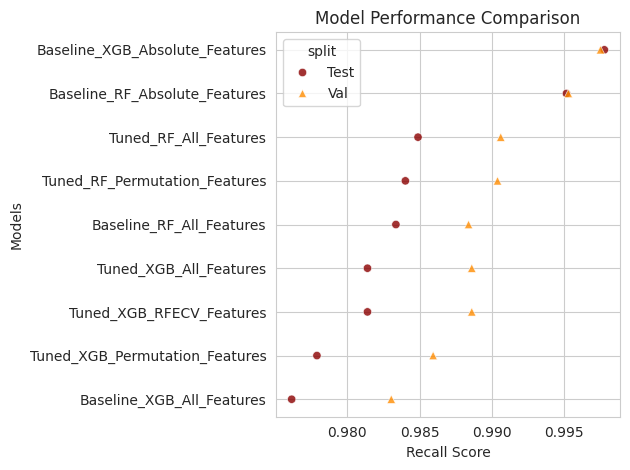

In [93]:
#results_df = pd.DataFrame(performances)
plot_best_model_splits(full_results, metric = 'recall')

compare results on test set, with those from val set. 
the baseline and tuned models using all features are directly comparable.
the feature reduced models were not fitted on the eval set and are not comparable.

major difference to the test set is that the threshold is optimized for eval, so performance should be better on that than on the test.

# compare model vs test set predictions

In [101]:
df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/test_df_with_predictions.csv')
relevant_columns = [ 'Label', 'Attack', 'Baseline_RF_Absolute_Features_Predictions', 'Baseline_XGB_Absolute_Features_Predictions',
                              'Baseline_RF_All_Features_Predictions','Tuned_RF_All_Features_Predictions','Tuned_RF_Permutation_Features_Predictions',
                            'Baseline_XGB_All_Features_Predictions','Tuned_XGB_All_Features_Predictions','Tuned_XGB_Permutation_Features_Predictions','Tuned_XGB_RFECV_Features_Predictions']

df = df[relevant_columns]

,Label,Attack,Baseline_RF_Absolute_Features_Predictions,Baseline_XGB_Absolute_Features_Predictions,Baseline_RF_All_Features_Predictions,Tuned_RF_All_Features_Predictions,Tuned_RF_Permutation_Features_Predictions,Baseline_XGB_All_Features_Predictions,Tuned_XGB_All_Features_Predictions,Tuned_XGB_Permutation_Features_Predictions,Tuned_XGB_RFECV_Features_Predictions
0,Benign,0,0,0,0,0,0,0,0,0,0
1,Benign,0,0,0,0,0,0,0,0,0,0
2,Benign,0,0,0,0,0,0,0,0,0,0
3,DDoS,1,1,1,1,1,1,1,1,1,1
4,DDoS,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
29995,Infiltration,1,1,1,1,1,1,1,1,1,1
29996,Infiltration,1,0,0,0,1,1,1,1,1,1
29997,Web Attack � Sql Injection,1,0,1,0,0,0,0,0,0,0
29998,Web Attack � Sql Injection,1,1,1,0,0,0,0,0,0,0


In [102]:
# Check if all model predictions are '0' (no attack predicted)
actual_attacks = df[df['Attack'] == 1]
prediction_columns = [col for col in df.columns if col.startswith('Baseline_') or col.startswith('Tuned_')]

failed_predictions = actual_attacks[(actual_attacks[prediction_columns] == 0).all(axis=1)]
failed_predictions_with_labels = failed_predictions[['Label'] + prediction_columns]

print(f"Number of cases where all models failed to predict an attack: {failed_predictions_with_labels.shape[0]}")
# Number of cases where all models failed to predict an attack: 52


Number of cases where all models failed to predict an attack: 5


In [71]:
# Check where best recall and f2 model predictions are '0' (no attack predicted)
actual_attacks = df[df['Attack'] == 1]
prediction_columns = [col for col in df.columns if col.startswith('Baseline_RF_A') or col.startswith('Tuned_RF_A')]

failed_predictions = actual_attacks[(actual_attacks[prediction_columns] == 0).all(axis=1)]
failed_predictions_with_labels = failed_predictions[['Label'] + prediction_columns]

print(f"Number of cases where best RF models failed to predict an attack: {failed_predictions_with_labels.shape[0]}")

Number of cases where all models failed to predict an attack: 63


In [73]:
failed_predictions_with_labels['Label'].value_counts()

Label
DoS Hulk                      25
Bot                            8
Web Attack � Brute Force       7
Web Attack � Sql Injection     6
SSH-Patator                    5
DoS GoldenEye                  4
Web Attack � XSS               3
DoS Slowhttptest               2
DoS slowloris                  1
PortScan                       1
Infiltration                   1
Name: count, dtype: int64

In [103]:
# Identify model prediction columns
all_model_columns = [col for col in df.columns if col.startswith('Baseline_') or col.startswith('Tuned_')]
rf_model_columns = [col for col in all_model_columns if '_RF_' in col]
xgb_model_columns = [col for col in all_model_columns if '_XGB_' in col]

# Calculate failures for each category
df['Total_Model_Failures'] = df[all_model_columns].apply(lambda x: (x == 0).sum(), axis=1)
df['RF_Model_Failures'] = df[rf_model_columns].apply(lambda x: (x == 0).sum(), axis=1)
df['XGB_Model_Failures'] = df[xgb_model_columns].apply(lambda x: (x == 0).sum(), axis=1)

df.head(4)

,Label,Attack,Baseline_RF_Absolute_Features_Predictions,Baseline_XGB_Absolute_Features_Predictions,Baseline_RF_All_Features_Predictions,Tuned_RF_All_Features_Predictions,Tuned_RF_Permutation_Features_Predictions,Baseline_XGB_All_Features_Predictions,Tuned_XGB_All_Features_Predictions,Tuned_XGB_Permutation_Features_Predictions,Tuned_XGB_RFECV_Features_Predictions,Total_Model_Failures,RF_Model_Failures,XGB_Model_Failures
0,Benign,0,0,0,0,0,0,0,0,0,0,9,4,5
1,Benign,0,0,0,0,0,0,0,0,0,0,9,4,5
2,Benign,0,0,0,0,0,0,0,0,0,0,9,4,5
3,DDoS,1,1,1,1,1,1,1,1,1,1,0,0,0


### create heatmap for failed predictions

In [104]:
# Define the model columns and filter attacks
model_columns = [col for col in df.columns if col.startswith('Baseline_') or col.startswith('Tuned_')]
actual_attacks = df[df['Attack'] == 1]

# Further filter to find rows where any model failed to predict the attack
failed_attacks_mask = actual_attacks[model_columns].apply(lambda x: (x == 0).any(), axis=1)
failed_attacks = actual_attacks[failed_attacks_mask]

# Create a binary DataFrame indicating failures (1) and successes (0)
failure_binary_df = failed_attacks[model_columns].applymap(lambda x: 1 if x == 0 else 0)

# Include the 'Label' column in the failure_binary_df for grouping
failure_binary_df['Label'] = failed_attacks['Label']

# Group by 'Label' and sort groups by their size
label_counts = failure_binary_df['Label'].value_counts()
#sorted_labels = label_counts.sort_values(ascending=True).index
sorted_labels = np.sort(failure_binary_df['Label'].unique())

# Sort the DataFrame by this order
failure_binary_df['Label'] = pd.Categorical(failure_binary_df['Label'], categories=sorted_labels, ordered=True)
sorted_failure_df = failure_binary_df.sort_values(by='Label')

# Separate the label for plotting and remove it from data for heatmap
labels = sorted_failure_df['Label']
sorted_failure_df = sorted_failure_df.drop(columns='Label')

# Transpose for heatmap plotting
sorted_failure_df_transposed = sorted_failure_df.T

/tmp/ipykernel_564/6323657.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  failure_binary_df = failed_attacks[model_columns].applymap(lambda x: 1 if x == 0 else 0)


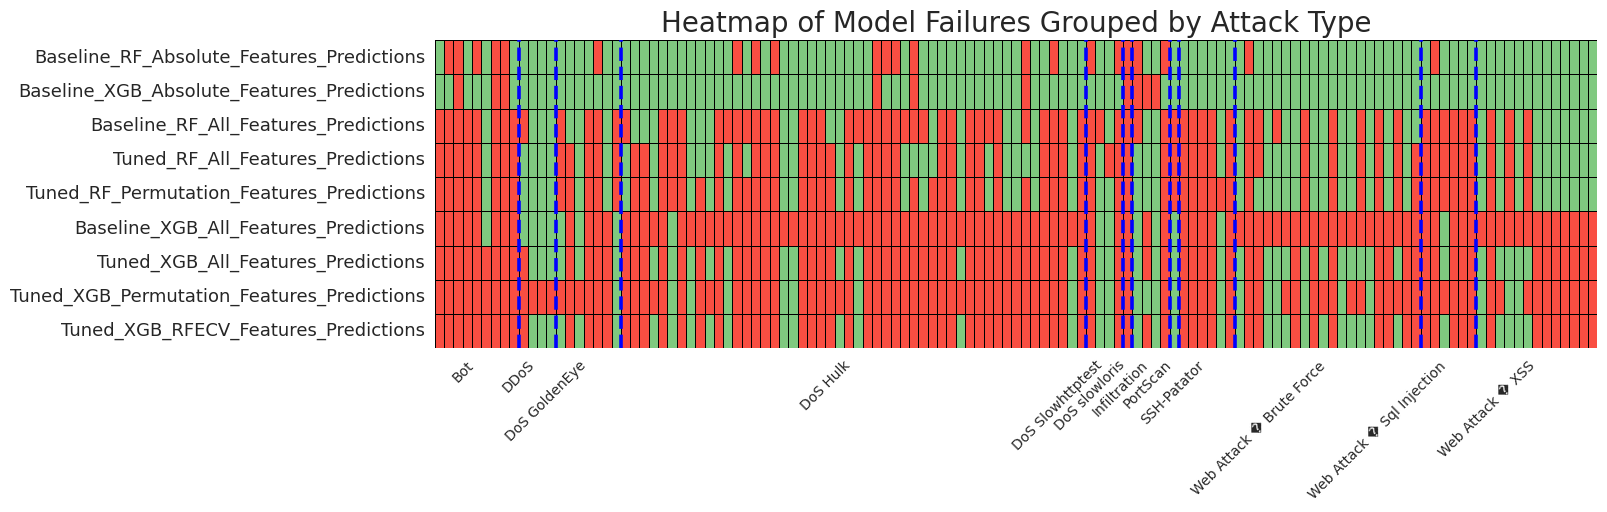

In [105]:
# plot heatmap
plt.figure(figsize=(15, 4))
cmap = mcolors.ListedColormap(['#7fc97f', '#f94e42']) #f0027f
ax = sns.heatmap(sorted_failure_df_transposed, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')

# Add vertical lines between groups
cumulative_counts = np.cumsum(label_counts[sorted_labels])
for count in cumulative_counts[:-1]:  # Skip the last line
    plt.axvline(x=count, color='blue', linestyle='--', linewidth=2.6)  # Change color and style as needed

# Setup x-ticks for attack types
tick_positions = cumulative_counts - label_counts[sorted_labels] / 2
plt.xticks(tick_positions, sorted_labels, rotation=45, ha='right')
plt.yticks(fontsize = 13)

ax.set_title('Heatmap of Model Failures Grouped by Attack Type', size = 20)
plt.show()

In [106]:
# get columns
model_columns = [col for col in df.columns if col.startswith('Baseline_') or col.startswith('Tuned_')]

# Create a binary DataFrame where 1 indicates a failure and 0 indicates a success
attack_cases = df[df['Attack'] == 1]

# For each model, mark failure (where prediction is 0) and success (where prediction is 1)
failure_binary_df = attack_cases[model_columns].applymap(lambda x: 1 if x == 0 else 0)
failure_binary_df['Label'] = attack_cases['Label']

# Group by 'Label' and calculate the mean of each group for each model
failure_rates = failure_binary_df.groupby('Label').mean()
failure_rates = failure_rates.T

# multiply by 100 to convert proportions to percentages
#failure_rates *= 100
failure_rates = failure_rates.round(2)
failure_rates


/tmp/ipykernel_564/431128620.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  failure_binary_df = attack_cases[model_columns].applymap(lambda x: 1 if x == 0 else 0)


Label,Bot,DDoS,DoS GoldenEye,DoS Hulk,DoS Slowhttptest,DoS slowloris,FTP-Patator,Heartbleed,Infiltration,PortScan,SSH-Patator,Web Attack � Brute Force,Web Attack � Sql Injection,Web Attack � XSS
Baseline_RF_Absolute_Features_Predictions,0.19,0.0,0.01,0.00,0.03,0.01,0.0,0.0,0.2,0.00,0.00,0.05,0.17,0.00
Baseline_XGB_Absolute_Features_Predictions,0.11,0.0,0.00,0.00,0.00,0.01,0.0,0.0,0.3,0.00,0.00,0.00,0.00,0.00
Baseline_RF_All_Features_Predictions,0.30,0.0,0.03,0.01,0.04,0.01,0.0,0.0,0.2,0.03,0.10,0.36,1.00,0.23
Tuned_RF_All_Features_Predictions,0.30,0.0,0.04,0.01,0.04,0.01,0.0,0.0,0.1,0.03,0.10,0.36,1.00,0.23
Tuned_RF_Permutation_Features_Predictions,0.30,0.0,0.04,0.01,0.03,0.01,0.0,0.0,0.1,0.03,0.12,0.32,1.00,0.23
Baseline_XGB_All_Features_Predictions,0.30,0.0,0.03,0.02,0.03,0.01,0.0,0.0,0.2,0.00,0.10,0.91,0.83,1.00
Tuned_XGB_All_Features_Predictions,0.33,0.0,0.03,0.02,0.03,0.01,0.0,0.0,0.2,0.00,0.10,0.41,0.83,0.62
Tuned_XGB_Permutation_Features_Predictions,0.33,0.0,0.04,0.02,0.03,0.01,0.0,0.0,0.1,0.00,0.10,0.64,1.00,0.77
Tuned_XGB_RFECV_Features_Predictions,0.33,0.0,0.03,0.02,0.03,0.01,0.0,0.0,0.2,0.00,0.10,0.41,0.83,0.62


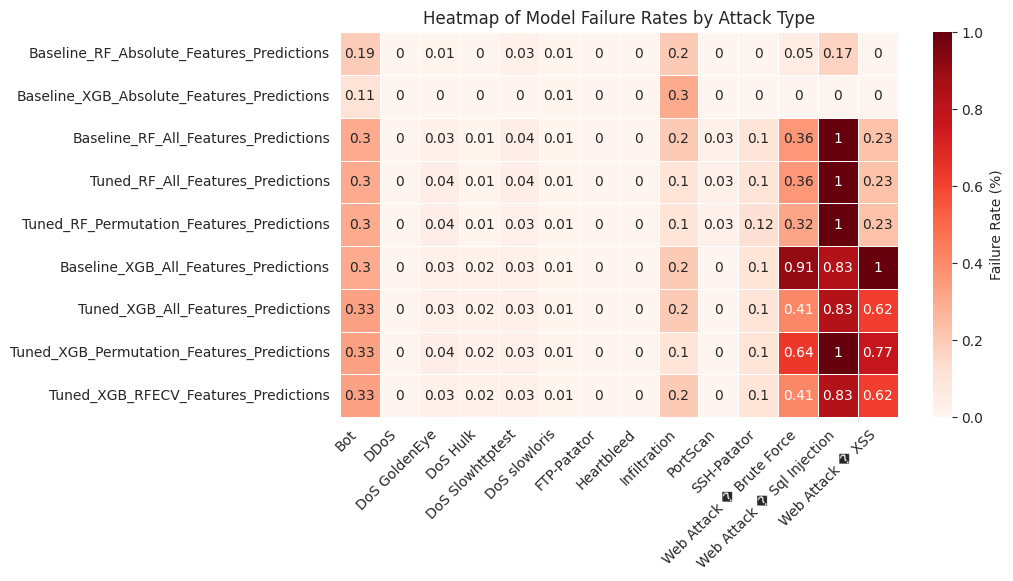

In [107]:
# Create heatmap of proportion of failures
plt.figure(figsize=(9, 5))
ax = sns.heatmap(failure_rates, annot=True, cmap='Reds', linewidths=.5, cbar_kws={'label': 'Failure Rate (%)'})
ax.set_title('Heatmap of Model Failure Rates by Attack Type')
plt.xticks(rotation=45, ha="right")
plt.xlabel('')
plt.show()


In [110]:
train_df['Label'].value_counts()

Label
Benign                        30000
DoS Hulk                      14004
DDoS                          10233
SSH-Patator                    1288
DoS GoldenEye                   839
PortScan                        782
Web Attack � Brute Force        588
Bot                             575
FTP-Patator                     521
DoS slowloris                   445
DoS Slowhttptest                436
Web Attack � XSS                261
Infiltration                     14
Web Attack � Sql Injection        9
Heartbleed                        5
Name: count, dtype: int64

In [66]:
# Calculate the counts of each label in the train, eval, and test datasets
train_counts = train_df['Label'].value_counts().rename('Train Count')
eval_counts = eval_df['Label'].value_counts().rename('Eval Count')
test_counts = test_df['Label'].value_counts().rename('Test Count')

# Combine counts into a single DataFrame
counts_df = pd.DataFrame([train_counts, eval_counts, test_counts]).T
counts_df.fillna(0, inplace=True)  # Replace NaNs with 0 where labels might not appear in one of the dataframes
failure_rates_transposed = failure_rates.T  # Transpose to have labels as rows and models as columns

failed_predictions_count = failure_binary_df.drop(columns='Label').apply(sum, axis=1)  # Sum failures across all models for each instance
failed_predictions_count = failure_binary_df.groupby('Label').apply(lambda df: df.drop(columns='Label').values.sum()).rename('Failed Predictions')

# Calculate the sum of failed predictions for each model within each label
model_failed_counts = failure_binary_df.groupby('Label')[model_columns].sum().add_suffix('_Failures')

# merging
final_stats = pd.concat([counts_df, failure_rates_transposed, model_failed_counts], axis=1)
final_stats


/tmp/ipykernel_564/3201499669.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  failed_predictions_count = failure_binary_df.groupby('Label').apply(lambda df: df.drop(columns='Label').values.sum()).rename('Failed Predictions')


,Train Count,Eval Count,Test Count,Baseline_RF_All_Features_Predictions,Tuned_RF_All_Features_Predictions,Tuned_RF_Permutation_Features_Predictions,Baseline_XGB_All_Features_Predictions,Tuned_XGB_All_Features_Predictions,Tuned_XGB_Permutation_Features_Predictions,Tuned_XGB_RFECV_Features_Predictions,Baseline_RF_All_Features_Predictions_Failures,Tuned_RF_All_Features_Predictions_Failures,Tuned_RF_Permutation_Features_Predictions_Failures,Baseline_XGB_All_Features_Predictions_Failures,Tuned_XGB_All_Features_Predictions_Failures,Tuned_XGB_Permutation_Features_Predictions_Failures,Tuned_XGB_RFECV_Features_Predictions_Failures
Label,,,,,,,,,,,,,,,,,
Benign,30000,25518,25432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DoS Hulk,14004,2304,2322,0.01,0.01,0.01,0.02,0.02,0.02,0.02,34.0,28.0,33.0,49.0,39.0,43.0,39.0
DDoS,10233,1703,1732,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,1.0,4.0,1.0
SSH-Patator,1288,34,48,0.10,0.10,0.12,0.10,0.10,0.10,0.10,5.0,5.0,6.0,5.0,5.0,5.0,5.0
DoS GoldenEye,839,133,139,0.03,0.04,0.04,0.03,0.03,0.04,0.03,4.0,5.0,5.0,4.0,4.0,6.0,4.0
PortScan,782,23,30,0.03,0.03,0.03,0.00,0.00,0.00,0.00,1.0,1.0,1.0,0.0,0.0,0.0,0.0
Web Attack � Brute Force,588,23,22,0.36,0.36,0.32,0.91,0.41,0.64,0.41,8.0,8.0,7.0,20.0,9.0,14.0,9.0
Bot,575,30,27,0.30,0.30,0.30,0.30,0.33,0.33,0.33,8.0,8.0,8.0,8.0,9.0,9.0,9.0
FTP-Patator,521,74,76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
final_stats.to_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/count_statistics.csv', index = False)